# Get Kaggle dataset

Upload kaggle.json

In [ ]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artemkramov","key":"e23e079bd58bf2b260208ca8c5d2d64c"}'}

Copy the JSON file, set permissions, show the list of Kaggle datasets to ensure that the `kaggle` command is working

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                        title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023              47KB  2023-08-26 11:04:57          12642        408  1.0              
joebeachcapital/students-performance                       Students Performance                           2KB  2023-08-31 00:50:11           4259        112  1.0              
carlmcbrideellis/zzzs-lightweight-training-dataset-target  Zzzs: Lightweight training dataset + target  185MB  2023-09-20 19:52:40            454         68  1.0              
iamsouravbanerjee/airline-dataset                          Airline Dataset                                8MB  2023-09-1

Download the dataset and unzip it

In [ ]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [06:34<00:00, 88.4MB/s]
100% 28.6G/28.6G [06:34<00:00, 77.8MB/s]


In [ ]:
!unzip airbus-ship-detection.zip -d "/content"

In [ ]:
!rm airbus-ship-detection.zip

In [ ]:
import os

print("Number of files in the training folder: {}".format(len(os.listdir("train_v2"))))

Number of files in the training folder: 192556


# Install dependencies

Install additional libraries and import dependencies

In [ ]:
!pip install -q mediapy
!pip install albumentations
!pip install datasets

In [ ]:
from os.path import join
import mediapy as media
import matplotlib.pyplot as plt
import os
import random
import cv2
import tqdm
import pandas as pd
import numpy as np
import albumentations as A
from datasets import Dataset

# Set global variables

In [ ]:
BASE_DIR = "/content"
TRAINING_DIR = join(BASE_DIR, "train_v2")
TRAINING_DATASET = join(BASE_DIR, "train_ship_segmentations_v2.csv")

# Load dataset data

In [ ]:
df = pd.read_csv(TRAINING_DATASET)

In [ ]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
print("Number of records within the dataset: {}".format(df.shape[0]))
print("Number of unique images within the dataset: {}".format(df['ImageId'].unique().shape[0]))

Number of records within the dataset: 231723
Number of unique images within the dataset: 192556


# Check aspect ratio, size

In [ ]:
# Add these lines to ensure that truncated images can be loaded (such images are presented in the dataset)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Read all available unique images in the training set and get their shapes
images_shapes = []
for file in tqdm.tqdm(df['ImageId'].unique()):
  image_path = os.path.join(TRAINING_DIR, file)
  image = media.read_image(image_path)
  images_shapes.append(image.shape)
  del image

100%|██████████| 192556/192556 [23:19<00:00, 137.61it/s]


In [ ]:
images_shapes_str = [str(shape) for shape in images_shapes]
print("Unique shapes of images: {}".format(np.unique(images_shapes_str)))

Unique shapes of images: ['(768, 768, 3)']


As far as all images share the same shape we can define the size of an image as a constant shape

In [ ]:
WIDTH = 768
HEIGHT = 768
NUM_CHANNELS = 3

# Util functions to process images

In [ ]:
def get_pixels_list_from_rle(rle):
  """
  Get the list of selected pixels from the RLE string
  :param str rle: RLE string to be processed
  :return: List of indices of pixels that corresponded to the RLE string
  :rtype: List[int]
  """
  pixels = []
  if rle != '':

    # Split the string by a space symbol
    elements = rle.split(' ')

    # Process pairs (start pixel, number of pixels) therefore
    # we are moving with the size step 2
    for i in range(0, len(elements), 2):
      start = int(elements[i])
      offset = int(elements[i + 1])
      end = start + offset
      pixels.extend(list(range(start, end)))
  return pixels

def get_mask_from_rle(rle, width=WIDTH, height=HEIGHT):
  """
  Get binary segmentation map (mask) from the provided RLE string
  :param str rle: RLE string
  :param int width: width of an output map in pixels
  :param int height: height of an output map in pixels
  :return: binary segmentation map (mask) where 1 represents the part of the ship, 0 is a background pixel
  :rtype: np.ndarray
  """

  # Init output map with zeros as a flattened array
  segmentation_map = np.zeros((width * height), dtype=np.uint8)

  # Get the list of pixels that correspond to ships and fill corresponding
  # map positions
  pixels = get_pixels_list_from_rle(rle)
  for pixel in pixels:
    segmentation_map[pixel] = 1

  # Reshape the map to the desired shape and transpose the matrix
  segmentation_map = segmentation_map.reshape((width, height)).T
  return segmentation_map

def get_mask_for_image(image_idx):
  """
  Given the ID of the image, the function returns the binary segmentation map (mask)
  :param str image_idx: ID of the image that is defined as a filename
  :return: binary segmentation map
  :rtype: np.ndarray
  """

  # Get dataset rows that correspond to the required image
  rows = df[df.ImageId == image_idx]

  # Collect all RLE strings of the image (each rle string correspond to
  # either empty image/one ship)
  rle = []
  for _, row in rows.iterrows():
    if not pd.isna(row['EncodedPixels']):
      rle.append(row['EncodedPixels'].strip())

  # Generate the segmentation map given all RLE strings
  segmentation_map = get_mask_from_rle(" ".join(rle))
  return segmentation_map

# Show samples from the dataset

Show some samples from the dataset to understand how they look like

In [ ]:
def show_resized_images(images):
  """
  Given the list of image arrays, the function resizes them and shows in the output
  :param List[np.ndarray] images: list of images to show
  :return: None
  """
  resize_shape = (200, 200)
  images_to_show = []
  for image in images:
    images_to_show.append(media.resize_image(image, resize_shape))

  media.show_images(images_to_show)

,,,,,,,,,,,,,,

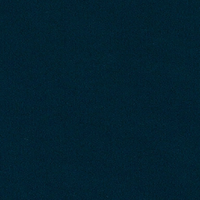
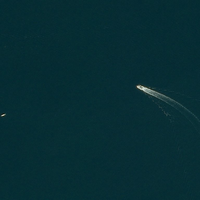
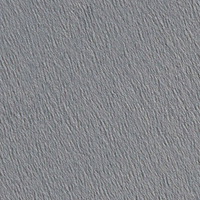
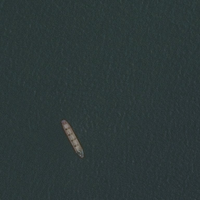
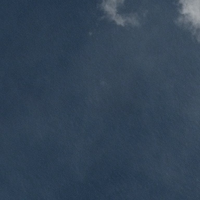
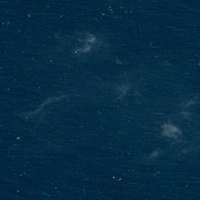
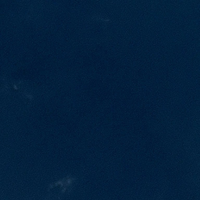
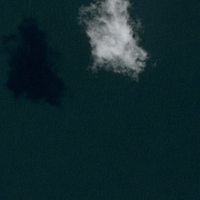
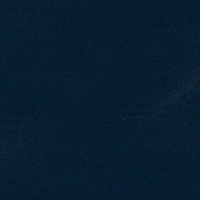
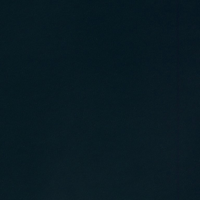
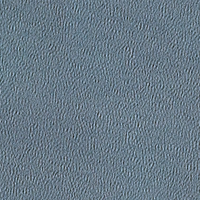
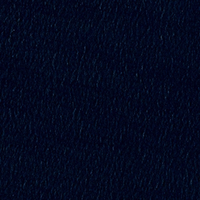
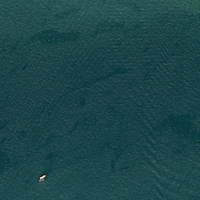
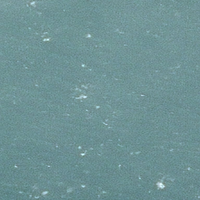
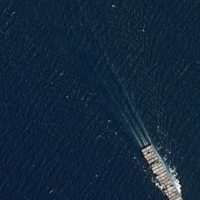

In [ ]:
# Pick N random images to display
N = 15
images_to_show = []
for file in random.sample(df['ImageId'].unique().tolist(), N):
  image_path = os.path.join(TRAINING_DIR, file)
  image = media.read_image(image_path)
  images_to_show.append(image)

show_resized_images(images_to_show)

It seems that most of images don't contain ships. Also, the distinguishing between a ship and its water path can potentially be challenging.

## Show masks for random image with ships

Take the random sample from the dataset and show an image and a mask

,

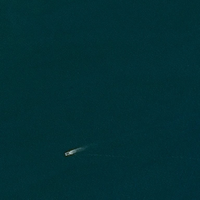
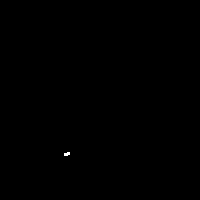

In [ ]:
filename = df[df.EncodedPixels.notna()].sample(1).iloc[0]['ImageId']

segmentation_map = get_mask_for_image(filename)
image = media.read_image(join(TRAINING_DIR, filename))
show_resized_images([image, segmentation_map])


# Analyze number of ships

Get the stats for the number of images with/without ships

Ratio of a number of samples without ships to a number of samples with ships: 3.525


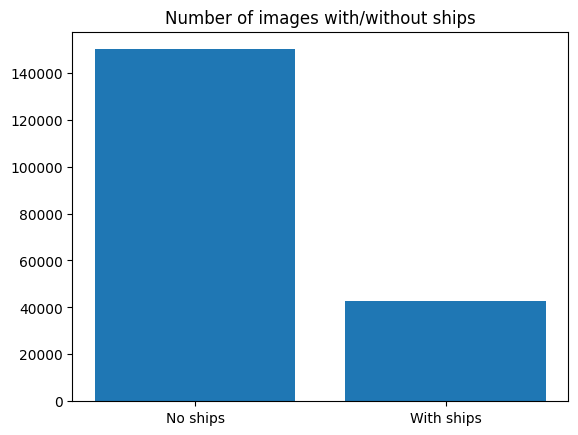

In [ ]:
# Get a number of samples without ships
num_empty_records = df[df['EncodedPixels'].isna()].shape[0]

# Get a number of samples with ships (don't forget to group ships per image)
num_images_with_ships = df[df['EncodedPixels'].notna()]['ImageId'].value_counts().shape[0]

print("Ratio of a number of samples without ships to a number of samples with ships: {:.3f}".format(num_empty_records / num_images_with_ships))
plt.bar(['No ships', 'With ships'], [num_empty_records, num_images_with_ships])
plt.title("Number of images with/without ships")
plt.show()

As can be seen, the dataset is imbalanced: a number of images with ships is less than a number of backgrounds only in ~3.5 times.

Now, we get the distribution of a number of ships per image where at least one ship is presented

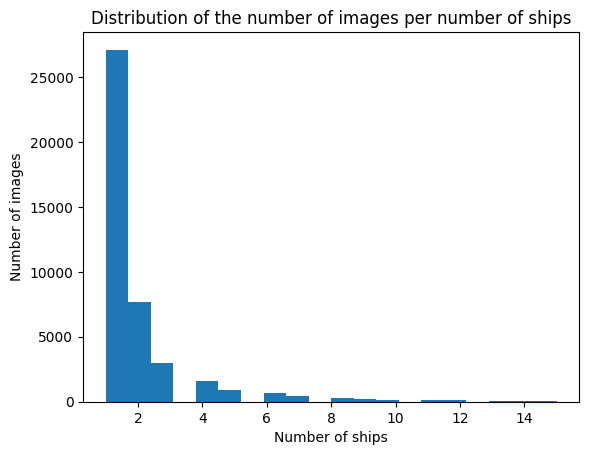

In [ ]:
num_ships_per_image = df[df['EncodedPixels'].notna()]['ImageId'].value_counts()
plt.hist(num_ships_per_image, bins=20)
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.title("Distribution of the number of images per number of ships")
plt.show()

The biggest amount of images contain 1-2 ships; however, there are samples with 3 more ships. Maybe it is advisable to either remove such cases or try to convert such samples to be an image with a single ship.

# Check sparsity of objects

Now we want to check how sparse is our segmentation map.

In [ ]:
# Collect all selected pixels per image
data_per_image = {}
for _, row in df[df['EncodedPixels'].notna()].iterrows():
  image_idx = row['ImageId']
  if not (image_idx in data_per_image):
    data_per_image[image_idx] = []
  data_per_image[image_idx].extend(get_pixels_list_from_rle(row['EncodedPixels']))


In [ ]:
# Calculate coverage as the ratio of selected pixels to their overall number
TOTAL_PIXELS = WIDTH * HEIGHT
coverage = []
for image_idx in data_per_image:
  coverage.append(len(data_per_image[image_idx]) / TOTAL_PIXELS)

In [ ]:
print("Avg. ship coverage per image: {:.4f}%".format(np.mean(coverage) * 100))

Avg. ship coverage per image: 0.5103%


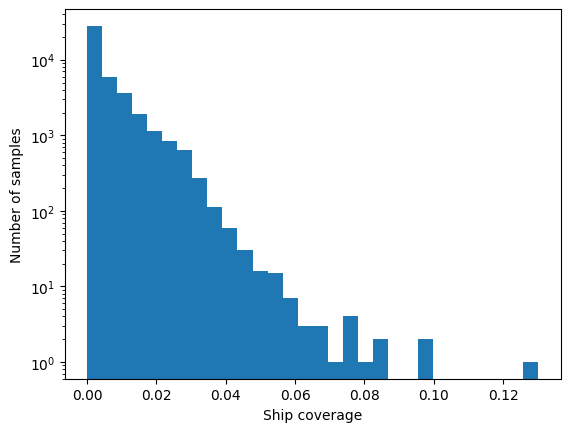

In [ ]:
plt.hist(coverage, bins=30)
plt.xlabel("Ship coverage")
plt.ylabel("Number of samples")
plt.yscale("log")
plt.show()

As far as the masks are pretty sparse, maybe the models that work well with the medical images can be suitable for this dataset.